In [2]:
import numpy as np
import scipy
import scipy.linalg

from matplotlib import pyplot as plt
from scipy.stats import ortho_group

In [64]:
def test_random_projection(n=5):
    """Within an n dimensional space, project an orthogonal set of k vectors (a k-dimensional subspace) into a space of dimension n-k
    where 1 vector is shared"""

    nsamples = 100

    testdim = np.arange(n+1)
    meanerror = np.zeros(testdim.size)
    stderror = np.zeros(testdim.size)
    nr_shared_vectors = 3

    for (j, k) in enumerate(testdim):
        # create an orthogonal set of random vectors
        U = ortho_group.rvs(dim=n)
        U = U[:, :k]
        error = np.zeros(nsamples)
        if k==0:
            continue
        for i in range(nsamples):
            # create k orthogonal vectors
            V = ortho_group.rvs(dim=n)
            V = V[:, :k]
            V[:,:nr_shared_vectors] = U[:,:nr_shared_vectors]
            error[i] = calculate_proj_error(U, V, 'F')
        meanerror[j] = np.mean(error)
        stderror[j] = np.std(error)

    expected_error = (testdim-nr_shared_vectors) * (n-testdim) / n
    expected_error_as_is = (testdim-nr_shared_vectors) * (n-testdim) / (n-nr_shared_vectors)
    plt.figure()
    plt.errorbar(testdim, meanerror, stderror)
    plt.errorbar(testdim, expected_error)
    plt.errorbar(testdim, expected_error_as_is)
                                                 

In [65]:
def project_orthogonal_to(subspace_basis, vectors_to_project):
    """
    Subspace basis: linearly independent (not necessarily orthogonal or normalized)
    vectors that span the space orthogonal to which we want to project
    vectors_to_project: project these vectors into the orthogonal complement of the
    specified subspace
    """

    if not scipy.sparse.issparse(vectors_to_project):
        V = np.matrix(vectors_to_project)
    else:
        V = vectors_to_project

    orthogonal_proj = V - project_to(subspace_basis, V)

    return orthogonal_proj

def project_to(subspace_basis, vectors_to_project):
    """
    Subspace basis: linearly independent (not necessarily orthogonal or normalized)
    vectors that span the space to which we want to project
    vectors_to_project: project these vectors into the specified subspace
    """

    if not scipy.sparse.issparse(vectors_to_project):
        V = np.matrix(vectors_to_project)
    else:
        V = vectors_to_project

    if not scipy.sparse.issparse(subspace_basis):
        S = np.matrix(subspace_basis)
    else:
        S = subspace_basis

    # compute S*(S^T*S)^{-1}*S'*V
    X1 = S.T * V
    X2 = S.T * S
    projected = S * scipy.linalg.solve(X2, X1)

    return projected

def calculate_proj_error(U, V, norm):
    proj1 = project_orthogonal_to(U, V)
    error = scipy.linalg.norm(proj1)**2

    return error

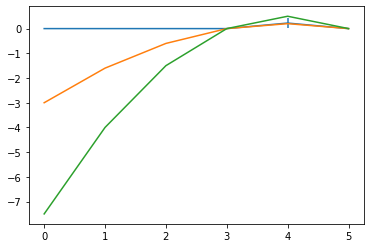

In [66]:
test_random_projection()